In [1]:
import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load Train data set

In [2]:
DATA_IN_PATH = './preprocessed_data/'
DATA_OUT = './data_out/'

In [3]:
TRAIN_Q1_DATA_FILE = 'q1_train.npy'
TRAIN_Q2_DATA_FILE = 'q2_train.npy'
TRAIN_LABEL_DATA_FILE = 'label_train.npy'
DATA_CONFIGS = 'data_configs.json'

In [4]:
train_q1_data = np.load(open(DATA_IN_PATH + TRAIN_Q1_DATA_FILE, 'rb'))
train_q2_data = np.load(open(DATA_IN_PATH + TRAIN_Q2_DATA_FILE, 'rb'))
train_labels = np.load(open(DATA_IN_PATH + TRAIN_LABEL_DATA_FILE, 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

# Modeling

In [5]:
model_name = 'malstm_similarity'B
BATCH_SIZE = 128
NUM_EPOCHS = 5
VALID_SPLIT = 0.1

kargs = {
    'vocab_size': prepro_configs['vocab_size'],
    'embedding_dimension': 100,
    'lstm_dimension': 150,
}

In [6]:
class Model(tf.keras.Model):
    def __init__(self, **kargs):
        super(Model, self).__init__(name=model_name)
        self.embedding = layers.Embedding(input_dim=kargs['vocab_size'], output_dim=kargs['embedding_dimension'])
        self.lstm = layers.LSTM(units=kargs['lstm_dimension'])

    def call(self, x):
        x1, x2 = x
        x1 = self.embedding(x1)
        x2 = self.embedding(x2)

        x1 = self.lstm(x1)
        x2 = self.lstm(x2)

        x = tf.exp(-tf.reduce_sum(tf.abs(x1 - x2), axis=1))

        return x

In [7]:
model = Model(**kargs)

In [8]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss=tf.keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

In [9]:
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=1, mode='max')

In [10]:
checkpoint_path = DATA_OUT+model_name+'/checkpoint.weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

In [11]:
if os.path.exists(checkpoint_dir):
    print('{} -- Folder already exists \n'.format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print('{} -- Folder create complete \n'.format(checkpoint_dir))

./data_out/malstm_similarity -- Folder create complete 



In [12]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True
)

In [13]:
history = model.fit((train_q1_data, train_q2_data), train_labels, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_split=VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

Epoch 1/5
2099/2100 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.6720 - loss: 0.6208
Epoch 1: val_accuracy improved from -inf to 0.92352, saving model to ./data_out/malstm_similarity/checkpoint.weights.h5
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 209s 99ms/step - accuracy: 0.6721 - loss: 0.6208 - val_accuracy: 0.9235 - val_loss: 0.2856
Epoch 2/5
2099/2100 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8038 - loss: 0.4281
Epoch 2: val_accuracy did not improve from 0.92352
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 217s 103ms/step - accuracy: 0.8038 - loss: 0.4281 - val_accuracy: 0.6009 - val_loss: 0.7872


# plot graph

In [14]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

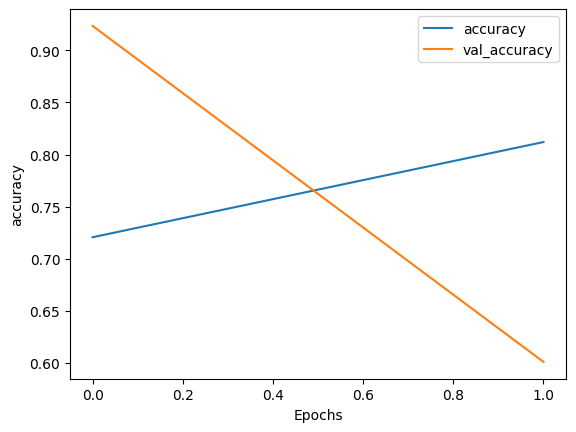

In [15]:
plot_graphs(history, 'accuracy')

# Evaluate Test Data

In [16]:
TEST_Q1_DATA = 'test_q1.npy'
TEST_Q2_DATA = 'test_q2.npy'
TEST_ID_DATA_FILE = 'test_id.npy'

In [17]:
test_q1_data = np.load(open(DATA_IN_PATH + TEST_Q1_DATA, 'rb'))
test_q2_data = np.load(open(DATA_IN_PATH + TEST_Q2_DATA, 'rb'))
test_id_data = np.load(open(DATA_IN_PATH + TEST_ID_DATA_FILE, 'rb'), allow_pickle=True)

In [18]:
SAVE_FILE_NM = 'checkpoint.weights.h5'
model.load_weights(os.path.join(DATA_OUT, model_name, SAVE_FILE_NM))

In [19]:
predictions = model.predict((test_q1_data, test_q2_data), batch_size=BATCH_SIZE)

18327/18327 ━━━━━━━━━━━━━━━━━━━━ 338s 18ms/step


ValueError: cannot select an axis to squeeze out which has size not equal to one

In [20]:
output = pd.DataFrame(data={'test_id' : test_id_data, 'is_duplicate': list(predictions)})
output.to_csv('malstm_predict.csv', index=False, quoting=3)